# Algoritmos Genéticos

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/flavio-mota/si-rna-ag-2025/blob/main/AG/Aula_10_Implementando_um_AG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

## Exemplo: maximizando uma função multimodal

Neste notebook vamos implementar passo a passo um Algoritmo Genético (AG) simples usando `numpy`.

O objetivo é resolver o problema apresentado em aula:

$$
f(x) = (x \bmod 7)^2 + \left\lfloor \frac{x}{3} \right\rfloor, \quad x \in \{0,1,2,\dots,31\}
$$

Usaremos:

- **Codificação binária**: cada indivíduo será um cromossomo com 5 bits, representando um inteiro entre 0 e 31;
- **Seleção por torneio**;
- **Crossover de um ponto**;
- **Mutação por inversão de bit**;
- Critério de parada: número fixo de gerações.

Ao longo do notebook, vamos relacionar cada etapa do código com os conceitos vistos na aula teórica: população, função de aptidão, seleção, operadores genéticos e critério de parada.

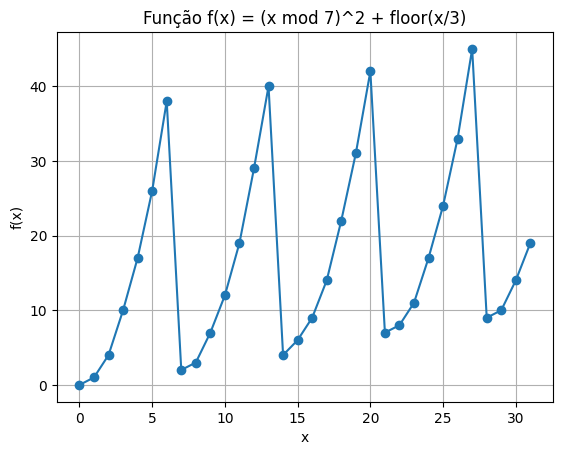

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Função objetivo f(x) = (x mod 7)^2 + floor(x/3)
def f(x: int) -> int:
    return (x % 7) ** 2 + (x // 3)  # // é divisão inteira (floor) em Python

# Visualizar a função no domínio 0..31
xs = np.arange(0, 32)
ys = np.array([f(int(x)) for x in xs])

plt.figure()
plt.plot(xs, ys, marker='o')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Função f(x) = (x mod 7)^2 + floor(x/3)')
plt.grid(True)
plt.show()

## Representação: codificação binária

Sabemos que na **codificação binária** cada indivíduo é um vetor de bits, e cada bit é um gene.  
Como queremos representar inteiros entre 0 e 31, precisamos de 5 bits:

- 00000 → 0  
- 11111 → 31  

Cada cromossomo será um `array` de 0s e 1s do `numpy`.

Vamos criar funções auxiliares:

- `int_to_bin(n, n_bits)`: converte um inteiro para um vetor binário (cromossomo);
- `bin_to_int(chromosome)`: converte um cromossomo de bits de volta para inteiro;
- `random_individual(n_bits)`: gera um indivíduo aleatório;
- `random_population(pop_size, n_bits)`: gera uma população inicial.


In [ ]:
N_BITS = 5  # 5 bits para representar 0..31

def int_to_bin(n: int, n_bits: int = N_BITS) -> np.ndarray:
    """Converte inteiro n para vetor de bits (mais significativo à esquerda)."""
    return np.array(list(np.binary_repr(n, width=n_bits))).astype(int)

def bin_to_int(chromosome: np.ndarray) -> int:
    """Converte um vetor de bits (0/1) para inteiro."""
    # Ex.: [1,0,1] -> '101' -> 5
    bits_str = ''.join(chromosome.astype(str))
    return int(bits_str, 2)

def random_individual(n_bits: int = N_BITS) -> np.ndarray:
    """Gera um indivíduo aleatório (cromossomo binário)."""
    return np.random.randint(0, 2, size=n_bits)

def random_population(pop_size: int, n_bits: int = N_BITS) -> np.ndarray:
    """Gera uma população inicial de tamanho pop_size."""
    return np.array([random_individual(n_bits) for _ in range(pop_size)])

# Exemplo: gerar uma população inicial pequena para visualizar
POP_SIZE = 6
pop = random_population(POP_SIZE)
pop, [bin_to_int(ind) for ind in pop]

(array([[1, 0, 1, 0, 0],
        [1, 1, 0, 0, 1],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 1, 1],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]),
 [20, 25, 16, 19, 16, 2])

## Função de aptidão (fitness)

A **avaliação** é o que conecta o AG ao problema.  
Aqui, a aptidão de um indivíduo é simplesmente o valor da função objetivo aplicada ao valor inteiro \(x\) representado pelo cromossomo.

Passos:

1. Converter cada cromossomo binário para seu valor inteiro `x`;
2. Calcular `f(x)` para obter a aptidão.

Vamos implementar uma função `fitness(population)` que recebe uma população (matriz `pop_size x n_bits`) e retorna um vetor com as aptidões de cada indivíduo.

In [ ]:
def fitness(population: np.ndarray) -> np.ndarray:
    """Calcula a aptidão de cada indivíduo da população."""
    fits = np.zeros(len(population))
    for i, chrom in enumerate(population):
        x = bin_to_int(chrom)
        fits[i] = f(x)
    return fits

# Testando a função de fitness na população inicial
fits = fitness(pop)
list(zip([bin_to_int(ind) for ind in pop], fits))

[(20, np.float64(42.0)),
 (25, np.float64(24.0)),
 (16, np.float64(9.0)),
 (19, np.float64(31.0)),
 (16, np.float64(9.0)),
 (2, np.float64(4.0))]

## Seleção: método por torneio

 Existem vários métodos de seleção, incluindo o **torneio**.

Ideia do torneio:

1. Sorteamos aleatoriamente `k` indivíduos da população.
2. Entre esses `k`, escolhemos o que tiver maior aptidão.
3. Repetimos o processo até termos o número de "pais" desejado.

Esse método favorece indivíduos com maior aptidão, mas ainda dá chance para outros, o que ajuda a manter diversidade.

Vamos implementar:

- `tournament_selection(population, fitness_values, k)`: retorna **um** indivíduo selecionado.
- Na hora de gerar a nova população, chamaremos essa função várias vezes.


In [ ]:
def tournament_selection(population: np.ndarray,
                         fitness_values: np.ndarray,
                         k: int = 3) -> np.ndarray:
    """Seleciona 1 indivíduo via torneio de tamanho k."""
    # Sorteia k índices
    indices = np.random.choice(len(population), size=k, replace=False)
    # Obtém as aptidões dos sorteados
    selected_fitness = fitness_values[indices]
    # Índice do melhor dentro do torneio
    winner_idx = indices[np.argmax(selected_fitness)]
    # Retorna uma cópia do cromossomo vencedor
    return population[winner_idx].copy()

# Exemplo de uso: rodar alguns torneios
for _ in range(5):
    winner = tournament_selection(pop, fits, k=3)
    print("Vencedor:", winner, "x =", bin_to_int(winner), "fitness =", f(bin_to_int(winner)))

Vencedor: [1 0 0 1 1] x = 19 fitness = 31
Vencedor: [1 0 0 1 1] x = 19 fitness = 31
Vencedor: [1 0 1 0 0] x = 20 fitness = 42
Vencedor: [1 0 1 0 0] x = 20 fitness = 42
Vencedor: [1 0 0 1 1] x = 19 fitness = 31


## Operador genético: crossover de um ponto

O **crossover de um ponto** para codificação binária funciona assim:

- Escolhemos dois pais `P1` e `P2`;
- Escolhemos aleatoriamente uma posição de corte;
- Construímos dois filhos:

$$
F1 = P1[:corte] + P2[corte:] \\
F2 = P2[:corte] + P1[corte:]
$$

Esse operador é aplicado com uma **taxa de crossover** $(p_c)$: com probabilidade $p_c$ fazemos crossover; caso contrário, apenas copiamos os pais.

Vamos implementar uma função `one_point_crossover(parent1, parent2, pc)`.


In [ ]:
def one_point_crossover(parent1: np.ndarray,
                        parent2: np.ndarray,
                        pc: float = 0.8):
    """Realiza crossover de um ponto entre dois pais."""
    n_bits = len(parent1)
    # Decide se crossover acontece
    if np.random.rand() < pc:
        # Sorteia ponto de corte entre 1 e n_bits-1
        point = np.random.randint(1, n_bits)
        child1 = np.concatenate([parent1[:point], parent2[point:]])
        child2 = np.concatenate([parent2[:point], parent1[point:]])
    else:
        # Sem crossover: apenas copia os pais
        child1, child2 = parent1.copy(), parent2.copy()
    return child1, child2

# Exemplo com dois indivíduos
p1 = random_individual()
p2 = random_individual()
c1, c2 = one_point_crossover(p1, p2, pc=1.0)  # força crossover
print("P1:", p1)
print("P2:", p2)
print("C1:", c1)
print("C2:", c2)

P1: [1 1 1 1 0]
P2: [1 1 0 1 0]
C1: [1 1 0 1 0]
C2: [1 1 1 1 0]


## Operador genético: mutação binária

Na **mutação para codificação binária** escolhemos um gene do cromossomo e invertemos seu valor (0 vira 1, 1 vira 0).  

Neste exemplo, vamos fazer algo ainda mais simples: percorrer cada bit do cromossomo e, com probabilidade $p_m$, inverter o bit.

Isso introduz diversidade na população, evitando que o AG fique preso muito cedo em um máximo local.

Vamos implementar `bit_flip_mutation(chromosome, pm)`.


In [ ]:
def bit_flip_mutation(chromosome: np.ndarray,
                      pm: float = 0.01) -> np.ndarray:
    """Aplica mutação de inversão de bits em um cromossomo."""
    mutant = chromosome.copy()
    for i in range(len(mutant)):
        if np.random.rand() < pm:
            mutant[i] = 1 - mutant[i]  # inverte 0->1 ou 1->0
    return mutant

# Exemplo de mutação
ind = random_individual()
mutant = bit_flip_mutation(ind, pm=0.5)  # prob. alta só para visualizar
print("Original:", ind)
print("Mutante :", mutant)

Original: [1 1 0 0 0]
Mutante : [1 1 0 1 1]


## Laço principal do Algoritmo Genético

Agora vamos juntar tudo, seguindo o fluxo mostrado no diagrama da aula:

1. Inicializar a população.
2. Avaliar a população (função de aptidão).
3. Repetir até o critério de parada (número de gerações):
   - Selecionar pais (seleção por torneio).
   - Aplicar crossover de um ponto.
   - Aplicar mutação binária.
   - Formar a nova população.
   - Avaliar a nova população.
   - Atualizar o melhor indivíduo encontrado.

Parâmetros principais:

- `POP_SIZE`: tamanho da população;
- `N_GEN`: número de gerações;
- `PC`: taxa de crossover;
- `PM`: taxa de mutação;
- `TOURNAMENT_K`: tamanho do torneio.

Vamos implementar uma função `genetic_algorithm(...)` que retorna o melhor indivíduo e a história da melhor aptidão ao longo das gerações.

In [ ]:
def genetic_algorithm(pop_size=20,
                      n_bits=5,
                      n_gen=50,
                      pc=0.8,
                      pm=0.01,
                      tournament_k=3,
                      verbose=False):
    # 1. População inicial
    population = random_population(pop_size, n_bits)
    best_fitness_history = []
    best_individual = None
    best_fit = -np.inf

    for gen in range(n_gen):
        # 2. Avaliação
        fits = fitness(population)

        # Atualiza melhor global
        gen_best_idx = np.argmax(fits)
        gen_best_fit = fits[gen_best_idx]
        if gen_best_fit > best_fit:
            best_fit = gen_best_fit
            best_individual = population[gen_best_idx].copy()

        best_fitness_history.append(best_fit)

        if verbose:
            print(f"Geração {gen:03d} | Melhor f(x) = {best_fit}")

        # 3. Nova população
        new_population = []

        # Geramos dois filhos por vez
        while len(new_population) < pop_size:
            # Seleção por torneio
            parent1 = tournament_selection(population, fits, k=tournament_k)
            parent2 = tournament_selection(population, fits, k=tournament_k)

            # Crossover
            child1, child2 = one_point_crossover(parent1, parent2, pc=pc)

            # Mutação
            child1 = bit_flip_mutation(child1, pm=pm)
            child2 = bit_flip_mutation(child2, pm=pm)

            new_population.append(child1)
            if len(new_population) < pop_size:
                new_population.append(child2)

        population = np.array(new_population)

    return best_individual, best_fit, np.array(best_fitness_history)

## Executando o AG e analisando a solução

Agora vamos rodar o algoritmo com um conjunto de parâmetros e observar:

- Qual valor de \(x\) o AG encontra como solução;
- Qual é o valor máximo de \(f(x)\) obtido;
- Como a melhor aptidão evolui ao longo das gerações.

Lembre que estamos lidando com uma função **multimodal** (vários máximos locais), então o AG precisa explorar o espaço de busca para evitar cair em máximos locais.

Geração 000 | Melhor f(x) = 17.0
Geração 001 | Melhor f(x) = 24.0
Geração 002 | Melhor f(x) = 24.0
Geração 003 | Melhor f(x) = 24.0
Geração 004 | Melhor f(x) = 33.0
Geração 005 | Melhor f(x) = 45.0
Geração 006 | Melhor f(x) = 45.0
Geração 007 | Melhor f(x) = 45.0
Geração 008 | Melhor f(x) = 45.0
Geração 009 | Melhor f(x) = 45.0
Geração 010 | Melhor f(x) = 45.0
Geração 011 | Melhor f(x) = 45.0
Geração 012 | Melhor f(x) = 45.0
Geração 013 | Melhor f(x) = 45.0
Geração 014 | Melhor f(x) = 45.0
Geração 015 | Melhor f(x) = 45.0
Geração 016 | Melhor f(x) = 45.0
Geração 017 | Melhor f(x) = 45.0
Geração 018 | Melhor f(x) = 45.0
Geração 019 | Melhor f(x) = 45.0
Geração 020 | Melhor f(x) = 45.0
Geração 021 | Melhor f(x) = 45.0
Geração 022 | Melhor f(x) = 45.0
Geração 023 | Melhor f(x) = 45.0
Geração 024 | Melhor f(x) = 45.0
Geração 025 | Melhor f(x) = 45.0
Geração 026 | Melhor f(x) = 45.0
Geração 027 | Melhor f(x) = 45.0
Geração 028 | Melhor f(x) = 45.0
Geração 029 | Melhor f(x) = 45.0
Geração 03

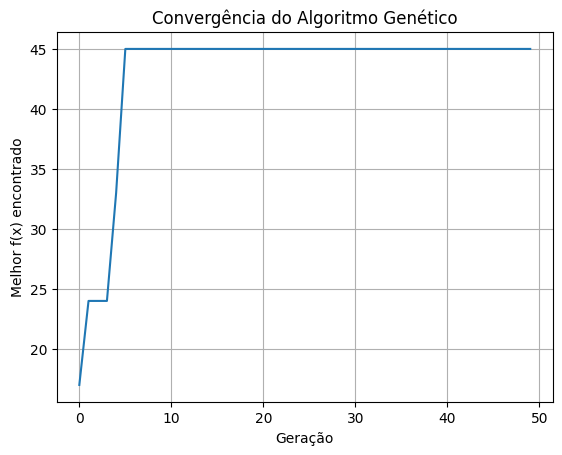

In [ ]:
best_ind, best_fit, history = genetic_algorithm(
    pop_size=10,
    n_bits=N_BITS,
    n_gen=50,
    pc=0.6,
    pm=0.01,
    tournament_k=2,
    verbose=True
)

best_x = bin_to_int(best_ind)

print("\nMelhor indivíduo encontrado:", best_ind)
print("x =", best_x)
print("f(x) =", best_fit)

plt.figure()
plt.plot(history)
plt.xlabel('Geração')
plt.ylabel('Melhor f(x) encontrado')
plt.title('Convergência do Algoritmo Genético')
plt.grid(True)
plt.show()

## Experimentos: influência dos parâmetros


1. Modifiquem o tamanho da população (`pop_size`) e observem o efeito na convergência.
2. Aumentem ou diminuam a taxa de crossover (`pc`) e vejam se o algoritmo converge mais rápido ou se fica instável.
3. Aumentem a taxa de mutação (`pm`) para valores mais altos (por exemplo, 0.05 ou 0.1) e observem:
   - O algoritmo explora mais o espaço?
   - A solução fica mais ruidosa?
4. Testem diferentes tamanhos de torneio (`tournament_k`):
   - Valores maiores tornam a seleção mais "agressiva" (mais pressão seletiva);
   - Valores menores mantêm mais diversidade.

Cada experimento pode ser executado chamando novamente `genetic_algorithm(...)` com diferentes combinações de parâmetros e comparando os gráficos de convergência.